![kernel](kernel-1.png)

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Dataset Basic Info

**Bank Note Authentication**

- Data were extracted from images that were taken from genuine and forged banknote-like specimens. 


- For digitization, an industrial camera usually used for print inspection was used. 


- The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object, gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool (image compression tool) were used to extract features from images.


- class:0 (authentic), 1(forgery)


- [data source link](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)

![basic-data-info](basic-data-info.png)

**Image Entropy Explanation**

- In Image, Entropy is defined as corresponding states of intensity level which individual pixels can adapt. 

- It is used in the quantitative analysis and evaluation image details, the entropy value is used as it provides better comparison of the image details

**DPI**

- DPI, or dots per inch, is a measure of the resolution of a printed document or digital scan. The higher the dot density, the higher the resolution of the print or scan. 

- Typically, DPI is the measure of the number of dots that can be placed in a line across one inch, or 2.54 centimeters.

**Pixel,Resolution and PPI**

- Pixel: This is the smallest building block of your screen. 

- Resolution: This is refers to the size of the pixel. The smaller the pixel, the higher the resolution.

- PPI:Image resolution is typically described in PPI, which refers to how many pixels are displayed per inch of an image. Higher resolutions mean that there more pixels per inch (PPI), resulting in more pixel information and creating a high-quality, crisp image

## Import and Explore Dataset

In [131]:
df = pd.read_csv('BankNote_Authentication.csv')
df.head(10)

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


In [45]:
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [44]:
# calculating ratio of forged banknotes
forge_ratio = round((df["class"][df["class"] == 1].count()/len(df["class"]))*100, 2)
print(f"the ratio of forged banknotes in the data is {forge_ratio}%")

the ratio of forged banknotes in the data is 44.46%


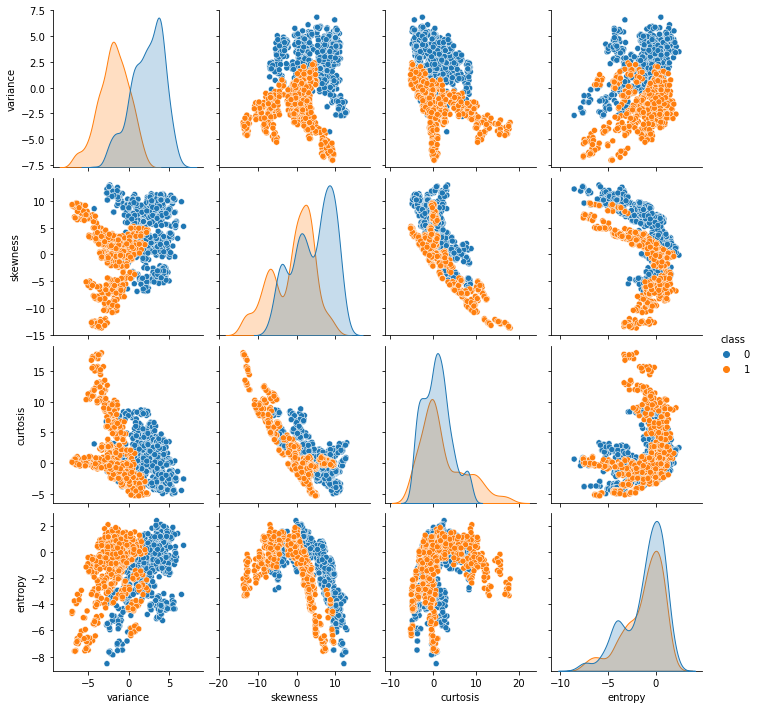

In [18]:
sns.pairplot(df, hue="class")

**PCA Exploration and t-sne**

In [3]:
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import manifold

In [132]:
X = df.iloc[: , :-1]
y = df.iloc[:, -1]

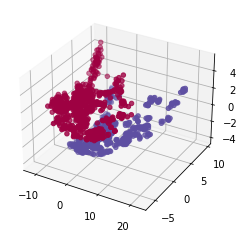

In [21]:
pca = PCA(n_components=3)
Y = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=y, cmap=plt.cm.Spectral)

ax.axis('tight')
plt.show()

Text(0.5, 1.0, '1 Feature')

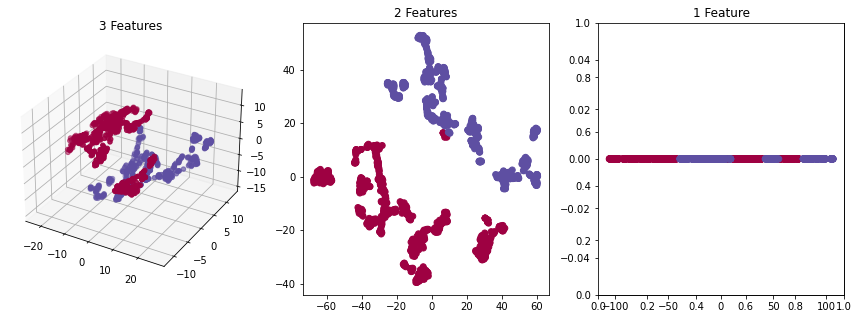

In [38]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
# 3d
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
PCA_3 = tsne.fit_transform(X)
ax1 = plt.subplot(131, projection="3d")
ax1.scatter(PCA_3[:, 0], PCA_3[:, 1], PCA_3[:, 2], c=y, cmap=plt.cm.Spectral)
ax1.set_title('3 Features')
# 2d
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
PCA_2 = tsne.fit_transform(X)
ax2 = plt.subplot(132)
ax2.scatter(PCA_2[:, 0],PCA_2[:, 1], c=y, cmap=plt.cm.Spectral)
ax2.set_title('2 Features')
# 1d
tsne = manifold.TSNE(n_components=1, init='pca', random_state=0)
PCA_1 = tsne.fit_transform(X)
ax3 = fig.add_subplot(133)
ax3.scatter(PCA_1[:, 0],np.zeros_like(PCA_1), c=y, cmap=plt.cm.Spectral)
ax3.set_title('1 Feature')

<div class="alert alert-block alert-info">
<b>Dataset Basic Information:</b> 
    
- Positive and negative class are relatively balanced
    
- Basic sns pairplot shows that positive and negative class has distictive variance and skewness
    
- TSNE works well for the 3D space plotting, however,plotting might not be efficient when applied in lower dimension.
    
- Show two clearly separable classes with little overlap in 2D,which may indicate that we are able to find a hyperplane in 3D (the hyperparameter selection of degree for polynomial kernel should be at least 3)
    
</div>

## SVM Model

### Evaluation Metrics Selection -- f1 and f2

In [3]:
# f2_scorer
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)

Possible metrics that can be optimized in the analysis include accuracy, precision, recall as well as different variations of the F$\beta$-score 

In this specific case of banknote forgery, we can assume that both unidentified forged banknotes, $\textit{false negatives (FNs)}$, and real banknotes identified as forged ones, $\textit{false positives (FPs)}$, play an important role as they come with costs in the form of inconveniences like unfounded accusations (for $\textit{FPs}$) and forged money in circulation (for $\textit{FNs}$)

As we want to take into account FPs and FNs we can utilize

- $recall = \frac{TPs}{TPs + FNs}$ taking into account $\textit{FNs}$ 
- $precision = \frac{TPs}{TPs + FPs}$ taking into account $\textit{FPs}$ 

Since the cost of not identifying forged banknotes ($\textit{FNs}$) and keeping counterfeit money in circulation for the future presumably is higher than identifying real banknotes as forged ($\textit{FP}$) we might also want to take a more specific look at keeping down $\textit{FNs}$

<div class="alert alert-block alert-info">
<b>Take away -- Evaluation Metrics:</b> 

-we use the $F_{\beta} = (1+\beta^2)\cdot \frac{precision \cdot recall}{\beta^2 \cdot precision + recall}$ in order to take into account both $\textit{FPs}$ and $\textit{FNs}$ via $\textit{precision}$ and $\textit{recall}$, respectively
    
-as we identified $\textit{FNs}$ to come with (presumably) higher costs, we not only use the $F_{\beta = 1}$ which assigns equal weights to $\textit{recall}$ and $\textit{precision}$ but also look at $F_{\beta = 2}$ that places more emphasis on the $\textit{recall}$ and thus $\textit{FNs}$
    
</div>

### Train/Test Split

In [133]:
X = df[df.columns[0:4]]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Learning Curve Ploting

**Plot polynomial curve**

In [48]:
def plot_poly_curve(gammas = "auto", Cs = 1, degrees = 3, scoring = f2):
    
    num_splits = 5 
    kfold = KFold(n_splits = 5) 
    
    if type(degrees) == np.ndarray:
        svm_poly = svm.SVC(kernel = "poly", gamma = gammas, C = Cs)
        num_values = len(degrees)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name = "degree", param_range = degrees, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "degree"
        xtick = np.arange(degrees.min(), degrees.max(), 1)
        Xs = degrees
        ylim = [0.45, 1]
        
    elif type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = "poly", gamma = gammas, degree = degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name = "C", param_range = Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "C"
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.98, 1]
        
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = "poly", degree = degrees, C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name = "gamma", param_range = gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "gamma"
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.98, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = "training")
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = "test")
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel("f2")
    elif scoring == "f1":
        plt.ylabel("f1")
    else:
        plt.ylabel("scoring")
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title("SVM with polynomial kernel")
    plt.legend()

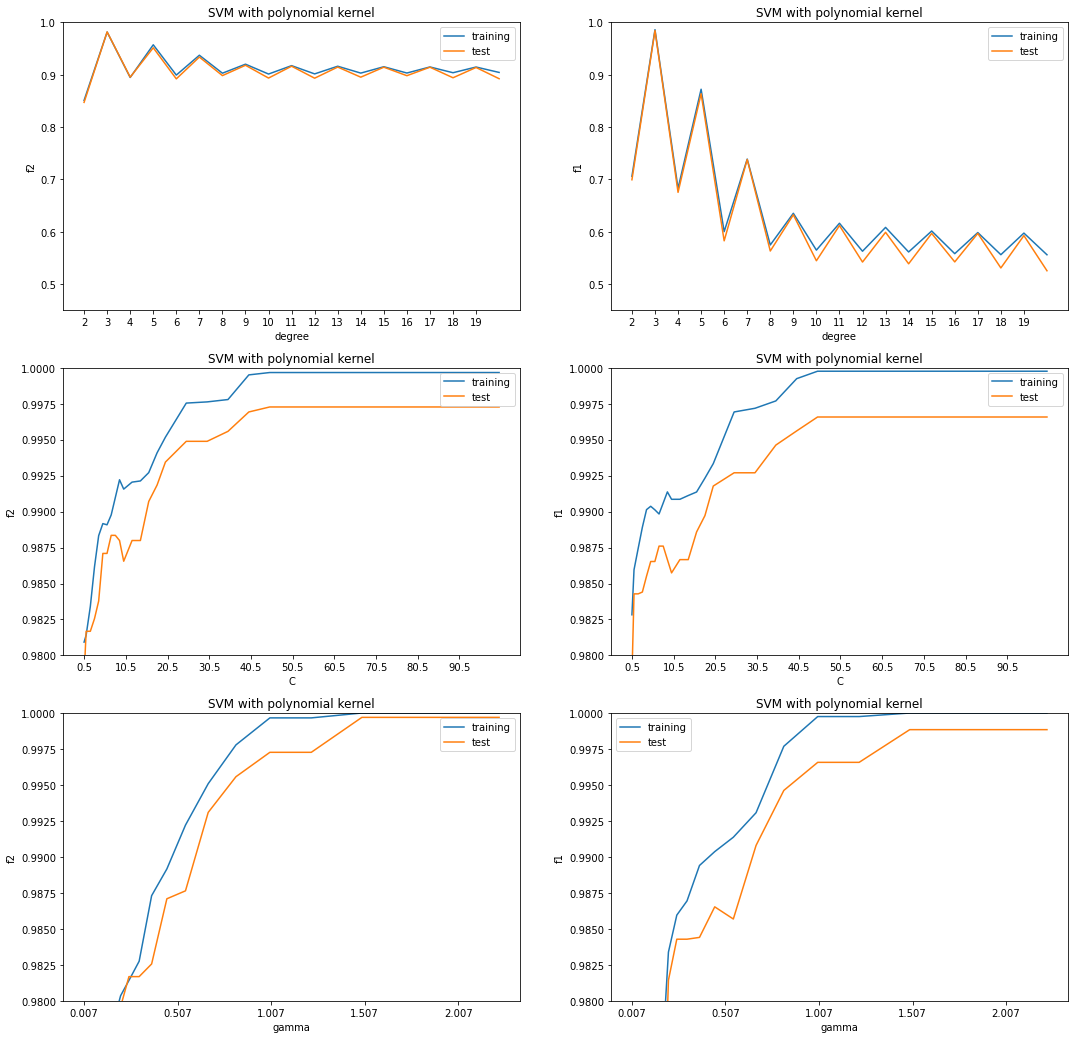

time spent: 11.501237869262695


In [49]:
start = time.time()

# plotting 
plt.figure(figsize = (18, 18))
degrees = np.arange(2, 21, 1) # choose/scan more systematically 
Cs = np.append(np.array([0.5]), np.append(np.append(np.arange(1, 10, 1), np.arange(10, 20, 2)), np.arange(20, 101, 5)))
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(3, 2, 1)
plot_poly_curve(degrees = degrees)
plt.subplot(3, 2, 2)
plot_poly_curve(degrees = degrees, scoring = "f1")
plt.subplot(3, 2, 3)
plot_poly_curve(Cs = Cs)
plt.subplot(3, 2, 4)
plot_poly_curve(Cs = Cs, scoring = "f1")
plt.subplot(3, 2, 5)
plot_poly_curve(gammas = gammas)
plt.subplot(3, 2, 6)
plot_poly_curve(gammas = gammas, scoring = "f1")

plt.show()


time_spent = time.time() - start
print(f"time spent: {time_spent}")

<div class="alert alert-block alert-info">
<b>Take away -- Polynomial Plot:</b> 
    
-odd degrees prove to be beneficial for both $F_{\beta = 2}$ and $F_{\beta = 1}$,
-the $F_{\beta = 1}$ decreases significantly with increasing degrees, as the precision is dragging the score down
    
-overfitting does not seem to play a major role as differences in training and test scores remain small

</div>

**Plot RBF Curve**

In [50]:
def plot_rbf_curve(gammas = "auto", Cs = 1, scoring = f2): 
    
    num_splits = 5 
    kfold = KFold(n_splits = 5)
    
    if type(Cs) == np.ndarray:
        svm_rbf = svm.SVC(kernel = "rbf", gamma = gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_rbf, X_train, y_train, 
                                                  param_name = "C", param_range = Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "C"
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.98, 1]
        
    elif type(gammas) == np.ndarray:
        svm_rbf = svm.SVC(kernel = "rbf", C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_rbf, X_train, y_train, 
                                                  param_name = "gamma", param_range = gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = "gamma"
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0.98, 1]
        
    else:
        raise TypeError

    train_scores_rbf = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_rbf = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_rbf.mean(axis=1), label = "training")
    plt.plot(Xs, valid_scores_rbf.mean(axis=1), label = "test")
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel("f2")
    elif scoring == "f1":
        plt.ylabel("f1")
    else:
        plt.ylabel("scoring")
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title("SVM with RBF kernel")
    plt.legend()  

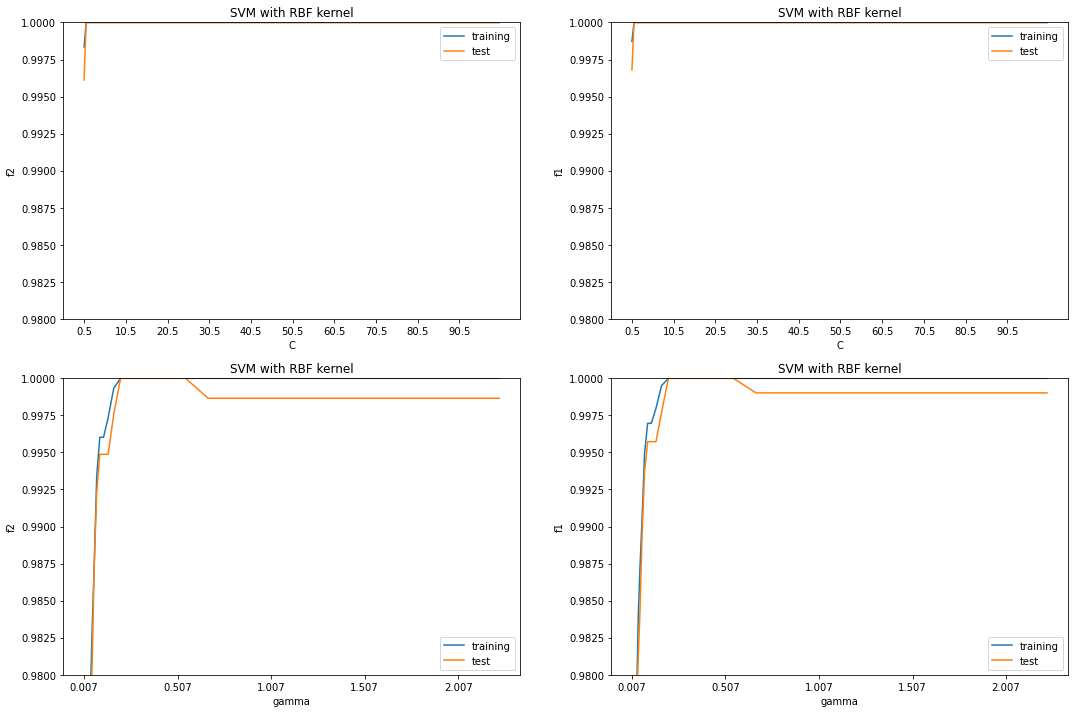

time spent: 5.768109083175659


In [51]:
start = time.time()

plt.figure(figsize = (18, 12))
plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = "f1")
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = "f1")
plt.show()

time_spent = time.time() - start
print(f"time spent: {time_spent}")

<div class="alert alert-block alert-info">
<b>Take away--RBF plot:</b> 
        
-the mere apllication of RBF seem to work extraordinarily well as $F_{\beta = 2}$ and $F_{\beta = 1}$ scores are close to 1 regardless of the hyperparameter combinations

-from eyeballing the scores, hyperparameter combinations with perfect training and test $F_{\beta = 2}$ and $F_{\beta = 1}$ scores can be identified

-increasing $\gamma$s seem to cause hints of overfitting
    
</div>

<div class="alert alert-block alert-info">
<b>Take away--RBF V.Polynomial:</b> 
        
-overall, we see that the underlying data is well-suited for SVMs as most scores are above 90% across different hyperparameters

-using RBF results in almost perfect scores from the get-go with arbitrarily chosen default hyperparameters
    
<div>

### Hyperparameter Tunning Using  Randomized Search and Girdsearch 

**RBF V. Poly**

We run the Gridsearch twice, though both achieved nearly perfect accuracy and recall score, the combinations of the hyperparameters show some differences, but we can still find some trend/similarities in the heatmap

- The best f1 score and f2 score are achieved when we use the rbf kernel, 


- Possible combination of the hyperparameters for the best f1_score (=1) are {'kernel'= 'rbf,'C'=100,'gamma'=0.1} and {'kernel'= 'rbf,'C'=10,'gamma'=0.25}


- Possible combination of the hyperparameters for the best f2_score (=1) are {'kernel'= 'rbf,'C'=100,'gamma'=0.1} and {'kernel'= 'rbf,'C'=1,'gamma'=0.25}


In [67]:
df_1 = pd.read_csv("GS_1_results_sorted_f1",delimiter = ",")
df_2 = pd.read_csv("GS_1_results_sorted_f2",delimiter = ",")
df_3 = pd.read_csv("GS_2_results_sorted_f1",delimiter = ",")
df_4 = pd.read_csv("GS_2_results_sorted_f2",delimiter = ",")

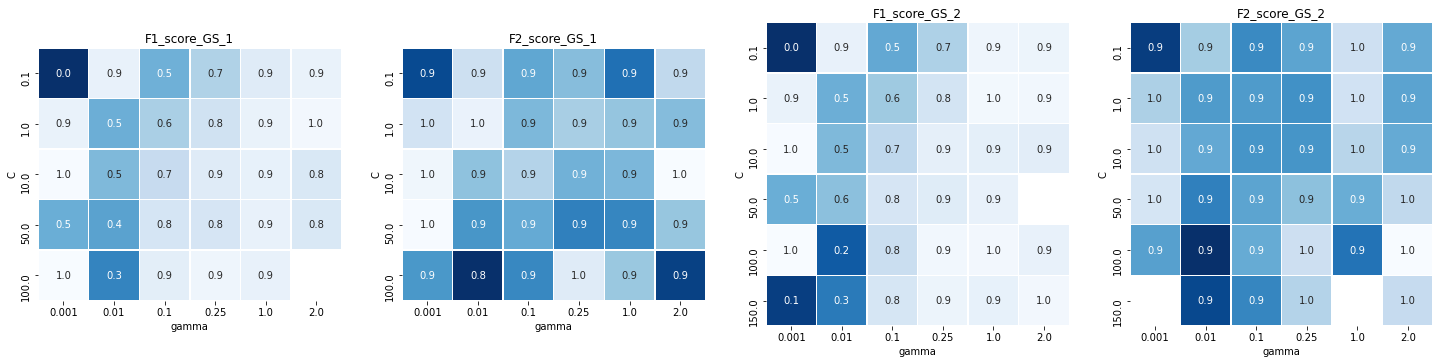

In [64]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(25,25));
# prepare wide form data for heatmap
# mean_test_f1
sns_data = df_1[['C','gamma','mean_test_f1']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f1')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Blues_r',ax=axes[0],cbar=False)


sns_data = df_3[['C','gamma','mean_test_f1']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f1')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Blues_r',ax=axes[2],cbar=False)

# mean_test_f2
sns_data = df_2[['C','gamma','mean_test_f2']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f2')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Blues_r',ax=axes[1],cbar=False)


sns_data = df_4[['C','gamma','mean_test_f2']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f2')
sns.heatmap(pivot_0_0,annot=True,fmt='.1f',linewidth=.5,square = True,cmap='Blues_r',ax=axes[3],cbar=False)



axes[0].title.set_text('F1_score_GS_1')
axes[1].title.set_text('F2_score_GS_1')
axes[2].title.set_text('F1_score_GS_2')
axes[3].title.set_text('F2_score_GS_2')

**Polynomial Optimization**

*Results from GridSearch CV*


- Possible combination of the hyperparameters for the best f1_score (0.99) is {C=1, gamma=2,degree = 3} 


- Possible combination of the hyperparameters for the best f2_score (0.99)is {C=1, gamma=2,degree = 3}  

*Results from RandomizedSearch CV*

- Possible combination of the hyperparameters for the best f1_score (0.99) is {C=5, gamma=4.92,degree = 3} 


- Possible combination of the hyperparameters for the best f2_score (0.99)is {C=5, gamma=4.92,degree = 3}  


In [123]:
df_poly_f1 = pd.read_csv("GS_poly_results_sorted_f1",delimiter = ",")
df_poly_f2 = pd.read_csv("GS_poly_results_sorted_f2",delimiter = ",")
df_rs_poly_f1 = pd.read_csv("RS_poly_results_sorted_f1",delimiter = ",")
df_rs_poly_f2 = pd.read_csv("RS_poly_results_sorted_f2",delimiter = ",")

**RBF Optimization**

*Results from GridSearch CV*

- Possible combination of the hyperparameters for the best f1_score (1) are {'C'=36,'gamma'=0.01} 


- Possible combination of the hyperparameters for the best f2_score (1) are {'C'=36,'gamma'=0.01} 

*Results from Randomized Search CV*

- Possible combination of the hyperparameters for the best f1_score (1) are {'C'=55.2,'gamma'=0.095} 


- Possible combination of the hyperparameters for the best f2_score (1) are {'C'=55.2,'gamma'=0.095} 

In [88]:
df_rbf_f1 = pd.read_csv("GS_rbf_results_sorted_f1",delimiter = ",")
df_rbf_f2 = pd.read_csv("GS_rbf_results_sorted_f2",delimiter = ",")

In [120]:
df_rs_rbf_f1 = pd.read_csv("RS_rbf_results_sorted_f1",delimiter = ",")
df_rs_rbf_f2 = pd.read_csv("RS_rbf_results_sorted_f2",delimiter = ",")

<AxesSubplot:xlabel='gamma', ylabel='C'>

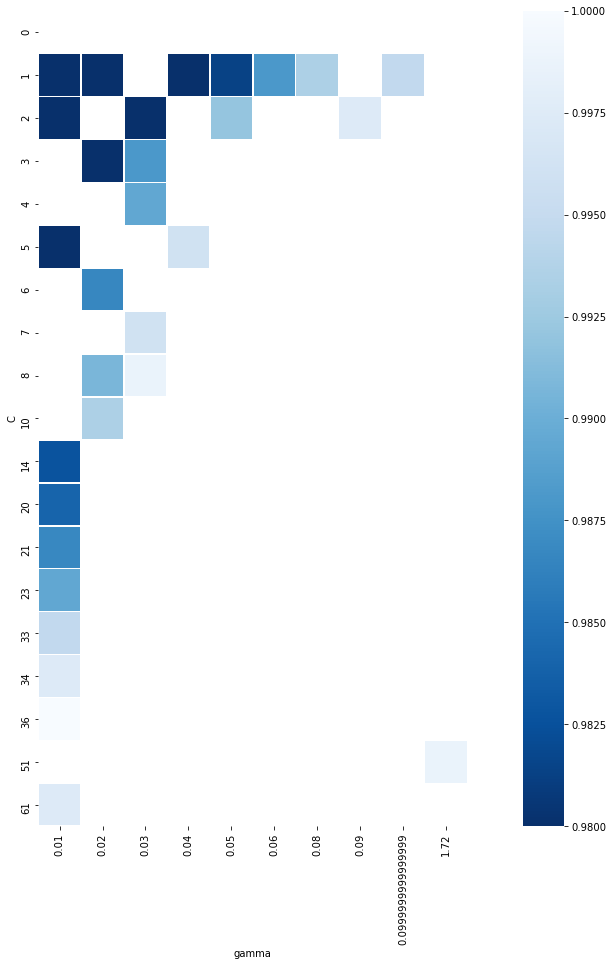

In [113]:
# Heatmap with F2-score optimization
# prepare wide form data for heatmap
# mean_test_f2

sns_data = df_rbf_f2[['C','gamma','mean_test_f2']]
sns_data = sns_data.groupby(['C','gamma']).mean()
sns_data = sns_data.reset_index()
pivot_0_0 = sns_data.pivot('C','gamma','mean_test_f2')
plt.subplots(figsize=(20,15))
sns.heatmap(pivot_0_0,annot=False,fmt='.1f',linewidth=.5,square = True,cmap='Blues_r',cbar=True,vmin=0.98, vmax=1)

<div class="alert alert-block alert-info">
<b>Take away </b> 
    
- Both the polynomial kernel and rbf kernel yielded nearly perfect accuracy and recall score.
    
    
- Comparing the C and gamma in the hyperparameter combination which produced the best results for polynomial kernel and rbf kernel, the C for polynomial kernel is relatively smaller than that of rbf kernel, while gamma for the polynomial kernel is relatively larger than that of the rbf kernel.
    
      
- The polynomial kernel is very computational demanding that even a small number of degrees such as [3,4] will make the search last FOREVER!!!!

</div>

**Confusion Matrix**

In [136]:
# rbf kernel best f2 score combination
svm_bestf2 = svm.SVC(C = 36, gamma = 0.01,kernel = 'rbf')
svm_bestf2.fit(X_train, y_train)


y_train_pred = svm_bestf2.predict(X_train)
y_test_pred = svm_bestf2.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f2_train = f2_scorer(y_train, y_train_pred)
f2_test = f2_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of training sample: ', f2_train)
print('f2 score of test sample: ', f2_test)


Confusion matrix of training sample: 
 [[605   0]
 [  0 492]]
Confusion matrix of test sample: 
 [[157   0]
 [  0 118]]
f2 score of training sample:  1.0
f2 score of test sample:  1.0


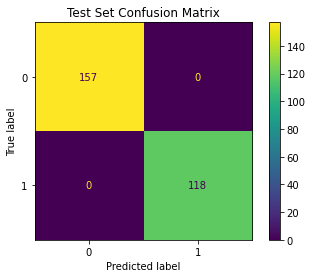

In [137]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svm_bestf2, X_test, y_test) 
plt.title('Test Set Confusion Matrix')
plt.show()

### Hyperparameter Optimization using Optuna

-- The hyperparameter combination found which gives the best f2 score is {kernel= rbf,C=8.89,gamma=0.05}


-- The hyperparameter combination found which gives the best f1 score is {kernel= rbf,C=1.05,gamma=8.19}

In [49]:
import optuna
import sklearn

In [52]:
#Set aside the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

**Using Optuna to optimize f2-score for polynimial kernel**

In [53]:
def model_performance(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return f2_scorer(y, y_pred)

def create_model(trial):
    regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
    gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
    degree = trial.suggest_int('degree', 3, 5)
    model = svm.SVC(kernel="poly", C=regularization,gamma=gamma,degree=degree)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 15:23:54,073] A new study created in memory with name: no-name-56d3f163-56dd-4fa1-ae41-ce7587151487
[I 2021-04-27 15:23:54,092] Trial 0 finished with value: 0.9919839679358717 and parameters: {'svm-regularization': 6.296642117560029, 'svm-gamma': 0.5967856391384166, 'degree': 5}. Best is trial 0 with value: 0.9919839679358717.
[I 2021-04-27 15:23:54,105] Trial 1 finished with value: 0.9797979797979797 and parameters: {'svm-regularization': 3.9519467345590207, 'svm-gamma': 3.6276041461110378, 'degree': 5}. Best is trial 0 with value: 0.9919839679358717.
[I 2021-04-27 15:23:54,114] Trial 2 finished with value: 0.9959758551307847 and parameters: {'svm-regularization': 5.211439826795015, 'svm-gamma': 6.517592325031055, 'degree': 3}. Best is trial 2 with value: 0.9959758551307847.
[I 2021-04-27 15:23:54,129] Trial 3 finished with value: 0.9797979797979797 and parameters: {'svm-regularization': 6.809747726685861, 'svm-gamma': 5.583952524512083, 'degree': 5}. Best is trial 2 wit

In [55]:
trial = study.best_trial
print('F2: {}'.format(trial.value))
print("Best hyperparameters of svm_poly_kernel: {}".format(trial.params))

F2: 0.9959758551307847
Best hyperparameters of svm_poly_kernel: {'svm-regularization': 5.211439826795015, 'svm-gamma': 6.517592325031055, 'degree': 3}


**Using Optuna to optimize f2-score for rbf kernel**

In [56]:
def model_performance(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return f2_scorer(y, y_pred)

def create_model(trial):
    regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
    gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
    model = svm.SVC(kernel="rbf", C=regularization,gamma=gamma)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

In [57]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 15:24:41,830] A new study created in memory with name: no-name-55aaab9e-132c-43dc-a89c-6c0de95a9996
[I 2021-04-27 15:24:41,845] Trial 0 finished with value: 1.0 and parameters: {'svm-regularization': 4.59764314800049, 'svm-gamma': 3.7318111851964226}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,860] Trial 1 finished with value: 1.0 and parameters: {'svm-regularization': 2.309051569907934, 'svm-gamma': 6.61857981716482}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,881] Trial 2 finished with value: 1.0 and parameters: {'svm-regularization': 0.377624186460142, 'svm-gamma': 9.555586697755587}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,903] Trial 3 finished with value: 1.0 and parameters: {'svm-regularization': 3.3059353788791914, 'svm-gamma': 8.451567376701876}. Best is trial 0 with value: 1.0.
[I 2021-04-27 15:24:41,914] Trial 4 finished with value: 1.0 and parameters: {'svm-regularization': 5.648367981557028, 'svm-gamma': 3.860127538498

In [58]:
trial = study.best_trial
print('F2: {}'.format(trial.value))
print("Best hyperparameters of svm_rbf_kernel: {}".format(trial.params))

F2: 1.0
Best hyperparameters of svm_rbf_kernel: {'svm-regularization': 4.59764314800049, 'svm-gamma': 3.7318111851964226}


**RBF V. Polynomial**

In [9]:
def model_performance(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return f2_scorer(y, y_pred)

def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['poly_svm', 'rbf_svm'])

    if model_type == 'poly_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        degree = trial.suggest_int('degree', 3, 5, 1)
        model = svm.SVC(kernel="poly", C=regularization,gamma=gamma,degree=degree)
        
        
    if model_type == 'rbf_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        model = svm.SVC(kernel='rbf', C=regularization, gamma=gamma)
        
    if trial.should_prune():
            raise optuna.TrialPruned()
            
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model)

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 11:24:43,079] A new study created in memory with name: no-name-c0450864-bf66-426d-a7b1-b60a01c66e89
[I 2021-04-27 11:24:43,090] Trial 0 finished with value: 1.0 and parameters: {'model_type': 'rbf_svm', 'svm-regularization': 8.896483763633299, 'svm-gamma': 0.05262273836649758}. Best is trial 0 with value: 1.0.
[I 2021-04-27 11:24:43,104] Trial 1 finished with value: 1.0 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 8.157609086762212, 'svm-gamma': 7.590886460519331, 'degree': 3}. Best is trial 0 with value: 1.0.
[I 2021-04-27 11:24:43,117] Trial 2 finished with value: 1.0 and parameters: {'model_type': 'rbf_svm', 'svm-regularization': 1.0736215399974398, 'svm-gamma': 2.613152682583091}. Best is trial 0 with value: 1.0.
[I 2021-04-27 11:24:43,131] Trial 3 finished with value: 1.0 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 2.4796518117537825, 'svm-gamma': 0.46389306077318454, 'degree': 3}. Best is trial 0 with value: 1.0.
[I 2021-04-2

In [11]:
trial = study.best_trial
print('F2: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

F2: 1.0
Best hyperparameters: {'model_type': 'rbf_svm', 'svm-regularization': 8.896483763633299, 'svm-gamma': 0.05262273836649758}


In [60]:
def model_performance_f1(model, X=X_val, y=y_val):
    """
    Get f2 score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return sklearn.metrics.f1_score(y, y_pred)

def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['poly_svm', 'rbf_svm'])

    if model_type == 'poly_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        degree = trial.suggest_int('degree', 3, 5, 1)
        model = svm.SVC(kernel="poly", C=regularization,gamma=gamma,degree=degree)
        
        
    if model_type == 'rbf_svm':
        regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
        gamma = trial.suggest_uniform('svm-gamma', 0.01, 10)
        model = svm.SVC(kernel='rbf', C=regularization, gamma=gamma)
        
    if trial.should_prune():
            raise optuna.TrialPruned()
            
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance_f1(model)

In [61]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2021-04-27 15:35:12,149] A new study created in memory with name: no-name-72cbdedd-9a53-48fd-8e93-e3e6ba27f3df
[I 2021-04-27 15:35:12,168] Trial 0 finished with value: 0.9868421052631579 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 2.0003204208265584, 'svm-gamma': 7.758012742590255, 'degree': 3}. Best is trial 0 with value: 0.9868421052631579.
[I 2021-04-27 15:35:12,186] Trial 1 finished with value: 1.0 and parameters: {'model_type': 'rbf_svm', 'svm-regularization': 1.0470224477010572, 'svm-gamma': 8.195089703916686}. Best is trial 1 with value: 1.0.
[I 2021-04-27 15:35:12,199] Trial 2 finished with value: 0.974025974025974 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 8.985657042445544, 'svm-gamma': 2.09585827709021, 'degree': 5}. Best is trial 1 with value: 1.0.
[I 2021-04-27 15:41:18,765] Trial 3 finished with value: 0.9358974358974359 and parameters: {'model_type': 'poly_svm', 'svm-regularization': 1.8691756813545182, 'svm-gamma': 7.7230979

In [62]:
trial = study.best_trial
print('F1: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

F1: 1.0
Best hyperparameters: {'model_type': 'rbf_svm', 'svm-regularization': 1.0470224477010572, 'svm-gamma': 8.195089703916686}


In [13]:
# test the result on test set
svm_bestf2 = svm.SVC(C = 8.89, 
                     gamma = 0.05,
                     kernel = 'rbf')
    
svm_bestf2.fit(X_train, y_train)

y_test_pred = svm_bestf2.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_test_pred)
f2_test = f2_scorer(y_test, y_test_pred)

print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of test sample: ', f2_test)

Confusion matrix of test sample: 
 [[157   0]
 [  0 118]]
f2 score of test sample:  1.0


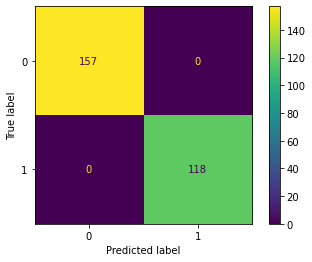

In [15]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svm_bestf2, X_test, y_test) 
plt.show()